## Try a simplist vae on midi data

In [1]:
import os
import pretty_midi
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

pygame 2.6.1 (SDL 2.28.4, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# load data
path = "../../dataset/midi_dataset/filtered_midi_imgs_100_000.npy"
# path = "../../dataset/quickdraw_dataset/The The Great Wall_100.npy"
midi_data = np.load(path, allow_pickle=True,)
print(f"Loaded {len(midi_data)} midi files from {path}")
print(f"Shape of midi data: {midi_data.shape}")



Loaded 100000 midi files from ../../dataset/midi_dataset/filtered_midi_imgs_100_000.npy
Shape of midi data: (100000, 100, 100)


Batch shape: torch.Size([256, 100, 100])


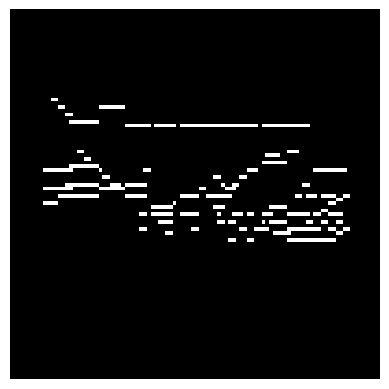

In [17]:
# make dataset 
import torch
from torch.utils.data import Dataset, DataLoader

picked_num = 100000
picked_midi = midi_data[:picked_num]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MidiDataset(Dataset):
    def __init__(self, midi_data):
        self.midi_data = midi_data

    def __len__(self):
        return len(self.midi_data)

    def __getitem__(self, idx):
        midi_file = self.midi_data[idx]
        return midi_file
# Create a dataset and dataloader
midi_dataset = MidiDataset(picked_midi)
midi_dataloader = DataLoader(midi_dataset, batch_size=256, shuffle=True)
# Check the shape of the data
for batch in midi_dataloader:
    print(f"Batch shape: {batch.shape}")
    break
# Visualize the data
def visualize_midi(midi_file):
    plt.imshow(midi_file, cmap='gray')
    plt.axis('off')
    plt.show()
# Visualize a random midi file
random_idx = random.randint(0, len(midi_data) - 1)
midi_file = midi_data[random_idx]
visualize_midi(midi_file)


In [6]:

# write a simplest vae model
from torch import nn
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2)  # output mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def compute_loss(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD* beta, BCE, KLD

In [6]:
def train(model, dataloader, optimizer, epochs=10, beta = 1):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            # print(f"min batch: {batch.min()}, max batch: {batch.max()}")
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss, bce, kld = compute_loss(recon_batch, batch, mu, logvar, beta)
            loss.backward()
            train_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
            optimizer.step()
        if epoch % 1 == 0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}, \
                  BCE: {bce_loss / len(dataloader.dataset)}, KLD: {kld_loss / len(dataloader.dataset)}")
        # print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}")

In [8]:
input_dim = 100 * 100  # Assuming the input is a flattened 100x100 image
hidden_dim = 2048
latent_dim = 256

model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [71]:
train(model, midi_dataloader, optimizer, epochs=50, beta = 5)
# save the model

model_path = "simpest_vae_model_midi.pth"
torch.save(model.state_dict(), model_path)

Epoch 1, Loss: 408.31963662109376,                   BCE: 253.83989475097655, KLD: 30.895948385620116
Epoch 2, Loss: 412.62637275390625,                   BCE: 258.01159445800783, KLD: 30.92295581970215
Epoch 3, Loss: 412.5958720703125,                   BCE: 257.59653950195315, KLD: 30.99986587524414
Epoch 4, Loss: 414.7663666015625,                   BCE: 259.68988740234374, KLD: 31.015296224975586
Epoch 5, Loss: 415.71849423828127,                   BCE: 260.65221040039063, KLD: 31.01325659790039
Epoch 6, Loss: 423.90046640625,                   BCE: 268.27482524414063, KLD: 31.12512829589844
Epoch 7, Loss: 433.45670625,                   BCE: 277.78379682617185, KLD: 31.134581253051756
Epoch 8, Loss: 426.9257251953125,                   BCE: 271.64052890625, KLD: 31.057038998413088
Epoch 9, Loss: 420.91062431640626,                   BCE: 266.0047684814453, KLD: 30.981170935058593
Epoch 10, Loss: 418.66401572265625,                   BCE: 263.64373828125, KLD: 31.004055087280275
Ep

In [10]:

# load the model
model_path = "simpest_vae_model_midi.pth"
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

/tmp/ipykernel_1837981/309224928.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=10000, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=10000, bias=True)
    (7): Sigmoid()
  )
)

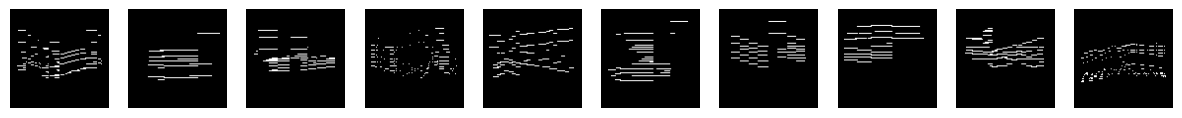

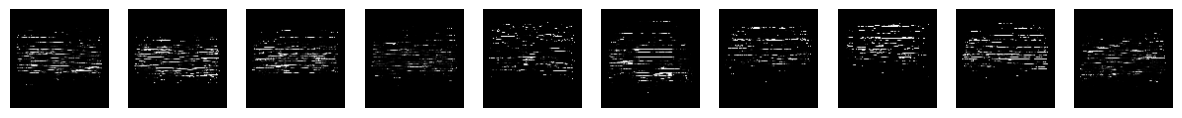

In [23]:
# reconstruct some images
def reconstruct_images(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            recon_batch, mu, logvar = model(batch)
            recon_batch = recon_batch.view(-1, 1, 100, 100).cpu().numpy()
            break
    return recon_batch[:num_images], batch[:num_images].view(-1, 1, 100, 100).cpu().numpy()
# Visualize the reconstructed images
def visualize_reconstructed_images(recon_images):
    fig, axes = plt.subplots(1, len(recon_images), figsize=(15, 5))
    for i, img in enumerate(recon_images):
        axes[i].imshow(img[0], cmap='gray')
        axes[i].axis('off')
    plt.show()
recon_images, ori_images = reconstruct_images(model, midi_dataloader, num_images=10)
visualize_reconstructed_images(ori_images)
visualize_reconstructed_images(recon_images)


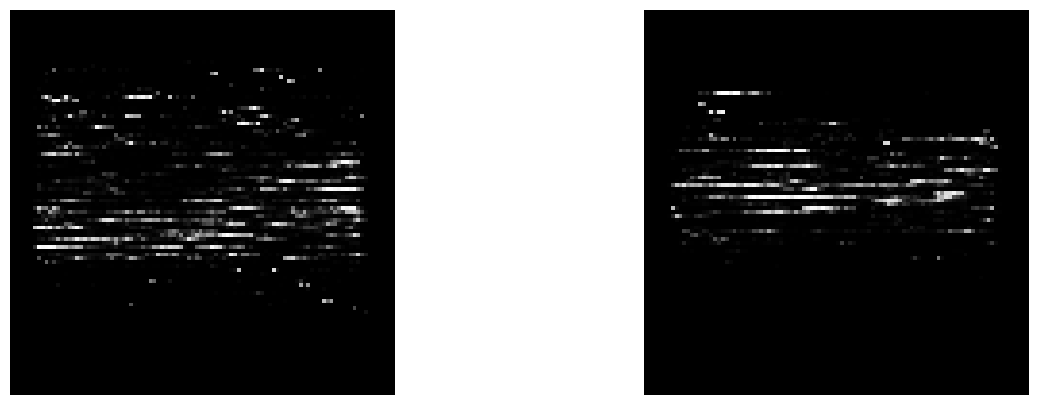

In [18]:
# sample from the model
def generate_sample(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device) 
        samples = model.decode(z).cpu()
        return samples
    
# visualize the samples
def visualize_samples(samples):
    samples = samples.view(-1, 100, 100)  # Reshape to original dimensions
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for i, sample in enumerate(samples):
        axes[i].imshow(sample.cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show() 
    
visualize_samples(generate_sample(model, num_samples=2))

In [15]:
from midi2img import img2midi

samples = generate_sample(model, num_samples=10)
for i, sample in enumerate(samples):
    sample = sample.view(100, 100).cpu().numpy()
    # print(sample.max())
    midi_file = img2midi(sample)
    midi_file.write(f"sample_{i}.mid")
    print(f"Saved sample_{i}.mid")
    
visualize_samples(samples)


2 0
Saved sample_0.mid
2 0
Saved sample_1.mid
2 0
Saved sample_2.mid
3 0


ValueError: data byte must be in range 0..127